## In this experiment, we are going to test 4 different model performance in irregular data <br>

## **1.  Synthetic Data**
1-1. irregular time series <br> 
1-2. regime switching data<br>

## **2. Continous model**
2-1. implement Neural ODEs <br>
2-2. implement Neural ODEs + Markov Chain <br>
2-3. plot comparison between this two model <br>

## **3.  Discrete Time Model**
3-1. implement LSTM<br>
3-1. implement Transformer<br>

## **4.  Comparison**
4-1. comparison of 4 models<br>
4-2. conclusion

# Imports

In [76]:
import torch 
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from torchdiffeq import odeint
import numpy as np


# **Synthetic regime-switching irregular data**

## Regime 0: Slow Sine Wave
## Regime 1: Fast Sine Wave
## Regime 2: Exponential Decay

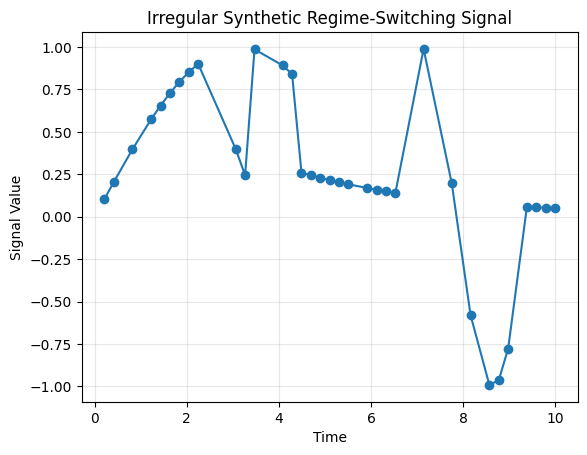

In [77]:
def generate_synthetic_data(T=1000, batch_size=1): ## T is number of timepoint

    ## Define the Markov Transition Matrix (How likely to switch from 1 Regime to Other)
    p = np.array([[0.8, 0.1, 0.1],
                  [0.2, 0.6, 0.2],
                  [0.1, 0.3, 0.6]])

    ## z will store the regime in each time point
    z = np.zeros((T, batch_size), dtype=int)

    ## y store the actual value of the signal based on z
    y = np.zeros((T, batch_size, 1))

    ## timepoint evenly spaced between 1 to 10
    t = np.linspace(0, 10, T)

   

    ## Generate Regime (each time step, z will contain regime lable)
    for a in range(batch_size):
        z[0, a] = 0 # initial regime
        for i in range(1, T):
            z[i, a] = np.random.choice(3, p=p[z[i-1, a]]) ## randomly pick regime based on P

        ## generate signal according to each regime
        for i in range(T):
            if z[i, a] == 0:
                y[i, a, 0] = np.sin(0.5*t[i])
            elif z[i, a] == 1:
                y[i, a, 0] = np.sin(2*t[i])
            else:
                y[i, a, 0] = np.exp(-0.3*t[i])

    ## Mask some of the timepoint 
    mask = np.random.rand(T) > 0.3 # keep 70% of data
    t_irregular = t[mask]
    y_irregular = y[mask, :, :]


    return torch.tensor(y, dtype=torch.float32), \
           torch.tensor(z), \
           torch.tensor(t, dtype=torch.float32), \
           torch.tensor(y_irregular, dtype=torch.float32), \
           torch.tensor(t_irregular, dtype=torch.float32)

        
            
    
y, z, t, y_irregular, t_irregular = generate_synthetic_data(T=50, batch_size=1)

plt.plot(t_irregular, y_irregular[:,0,0].numpy(), marker='o')
plt.title("Irregular Synthetic Regime-Switching Signal")
plt.xlabel("Time")          # ✅ x-axis label
plt.ylabel("Signal Value")  # ✅ y-axis label
plt.grid(True, alpha=0.3)   # optional, looks nicer
plt.show()

    

    

# **Baseline Neural ODE**

### define the dynamics model
f(y) = NN(y)

In [78]:
class ODEFunc(nn.Module):
    def __init__(self, hidden_dim = 20):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, t, y):
        return self.net(y)

### NeuralODE -- the integrator

In [79]:
class NeuralODE(nn.Module):

    def __init__(self, func): ## store the dynamic function
        super().__init__()
        self.func = func

    def forward(self, y0, t):
        out = odeint(self.func, y0, t)
        return out  

## **Hybrid Markov-Neural ODE**
Idea: <br>
-->K expert(each expert is a ODE Func) <br>
-->Markov chain picks regime z_t <br>
-->Use soft assignment during training <br>

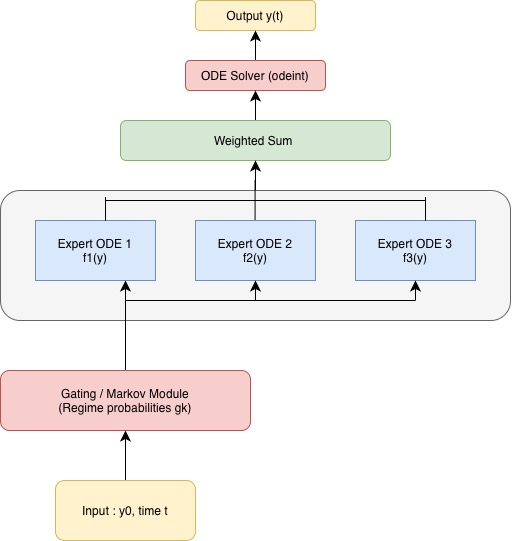

In [80]:
class HybridODE(nn.Module):
    def __init__(self, K = 3, hidden_dim=20 ):
        super().__init__()
        self.K = K
        ## self.experts = [ODEFunc(hidden_dim), ODEFunc(hidden_dim), ODEFunc(hidden_dim)]
        self.experts = nn.ModuleList([ODEFunc(hidden_dim) for x in range (K)])
        # a learnable tensor
        self.logits = nn.Parameter(torch.zeros(K))

    def forward(self, y0, t):
        ## compute the soft weight for each expert
        g = torch.softmax(self.logits, dim=0)

        ## compute the average of all expert trajectories 
        dy = 0
        for  x in range(self.K):
            out = odeint(self.experts[x], y0, t)
            dy += g[x] * out
        return dy ## [Time, batch, 1]

## **Training Loop**

In [81]:
def train_model(model, y, t, epochs=300, lr=1e-2):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    y0 = y[0]  # initial state

    for epoch in range(epochs):
        optimizer.zero_grad()
        pred = model(y0, t)
        loss = criterion(pred, y)
        loss.backward()
        optimizer.step()
        if (epoch+1) % 50 == 0:
            print(f"Epoch {epoch+1}: Loss={loss.item():.4f}")

    return model

## Train baseline Neural ODE and Hybrid ODE

In [82]:
## Baseline ODE

func = ODEFunc()
neural_ode = NeuralODE(func)
neural_ode = train_model(neural_ode, y_irregular, t_irregular)

## Hybrid Model
hybrid = HybridODE(K=3)
hybrid = train_model(hybrid, y_irregular, t_irregular)

Epoch 50: Loss=0.2583
Epoch 100: Loss=0.2568
Epoch 150: Loss=0.2562
Epoch 200: Loss=0.2556
Epoch 250: Loss=0.2549
Epoch 300: Loss=0.2543
Epoch 50: Loss=0.2503
Epoch 100: Loss=0.1306
Epoch 150: Loss=0.1228
Epoch 200: Loss=0.1216
Epoch 250: Loss=0.1212
Epoch 300: Loss=0.1209


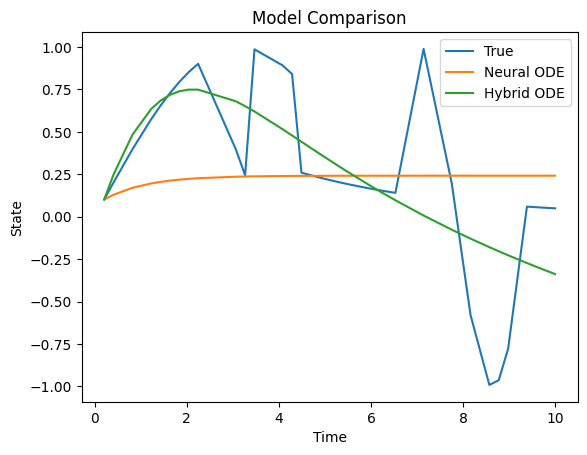

In [83]:
plt.plot(t_irregular, y_irregular[:,0,0].numpy(), label="True")

plt.plot(
    t_irregular,
    neural_ode(y_irregular[0], t_irregular).detach()[:,0,0].numpy(),
    label="Neural ODE"
)

plt.plot(
    t_irregular,
    hybrid(y_irregular[0], t_irregular).detach()[:,0,0].numpy(),
    label="Hybrid ODE"
)

plt.legend()
plt.title("Model Comparison")
plt.xlabel("Time")
plt.ylabel("State")
plt.show()



# **Discrete Model**

## **LSTM Baseline**

In [84]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=32):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out)

Prepare data

In [85]:
dt = t_irregular[1:] - t_irregular[:-1]
dt = torch.cat([dt[:1], dt])[:,None,None]

x_lstm = torch.cat([y_irregular, dt], dim=-1).permute(1,0,2)
y_target = y_irregular.permute(1,0,2)

## **Transformer baseline**

In [86]:
class TransformerModel(nn.Module):
    def __init__(self, input_dim=2, d_model=32):
        super().__init__()
        self.embed = nn.Linear(input_dim, d_model)
        layer = nn.TransformerEncoderLayer(d_model, nhead=4, batch_first=True)
        self.tr = nn.TransformerEncoder(layer, num_layers=2)
        self.fc = nn.Linear(d_model, 1)

    def forward(self, x):
        x = self.embed(x)
        x = self.tr(x)
        return self.fc(x)

## Training loop for sequence models

In [87]:
def train_model_seq(model, x, y, epochs=300, lr=1e-2):
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()

    for e in range(epochs):
        opt.zero_grad()
        pred = model(x)
        loss = loss_fn(pred, y)
        loss.backward()
        opt.step()

        if e % 50 == 0:
            print(f"Epoch {e}: {loss.item():.4f}")

    return model

Train:

In [88]:
lstm = LSTMModel()
transformer = TransformerModel()

train_model_seq(lstm, x_lstm, y_target)
train_model_seq(transformer, x_lstm, y_target)

Epoch 0: 0.3902
Epoch 50: 0.0020
Epoch 100: 0.0001
Epoch 150: 0.0000
Epoch 200: 0.0000
Epoch 250: 0.0000
Epoch 0: 0.2485
Epoch 50: 0.0101
Epoch 100: 0.0060
Epoch 150: 0.0096
Epoch 200: 0.0038
Epoch 250: 0.0037


TransformerModel(
  (embed): Linear(in_features=2, out_features=32, bias=True)
  (tr): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=32, out_features=32, bias=True)
        )
        (linear1): Linear(in_features=32, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=2048, out_features=32, bias=True)
        (norm1): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (fc): Linear(in_features=32, out_features=1, bias=True)
)

## Plot Comparison

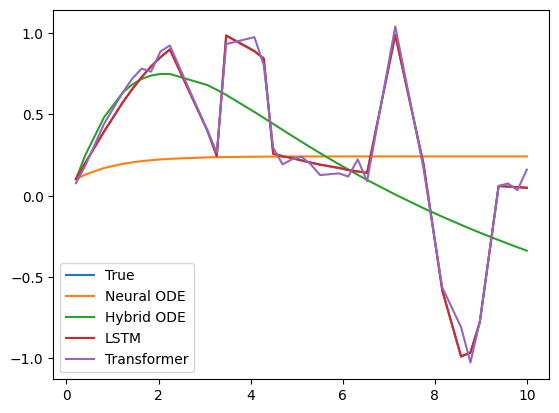

In [89]:
plt.plot(t_irregular, y_irregular[:,0,0], label="True")

plt.plot(t_irregular,
         neural_ode(y_irregular[0], t_irregular).detach()[:,0,0],
         label="Neural ODE")

plt.plot(t_irregular,
         hybrid(y_irregular[0], t_irregular).detach()[:,0,0],
         label="Hybrid ODE")

plt.plot(t_irregular,
         lstm(x_lstm).detach()[0,:,0],
         label="LSTM")

plt.plot(t_irregular,
         transformer(x_lstm).detach()[0,:,0],
         label="Transformer")

plt.legend()
plt.show()


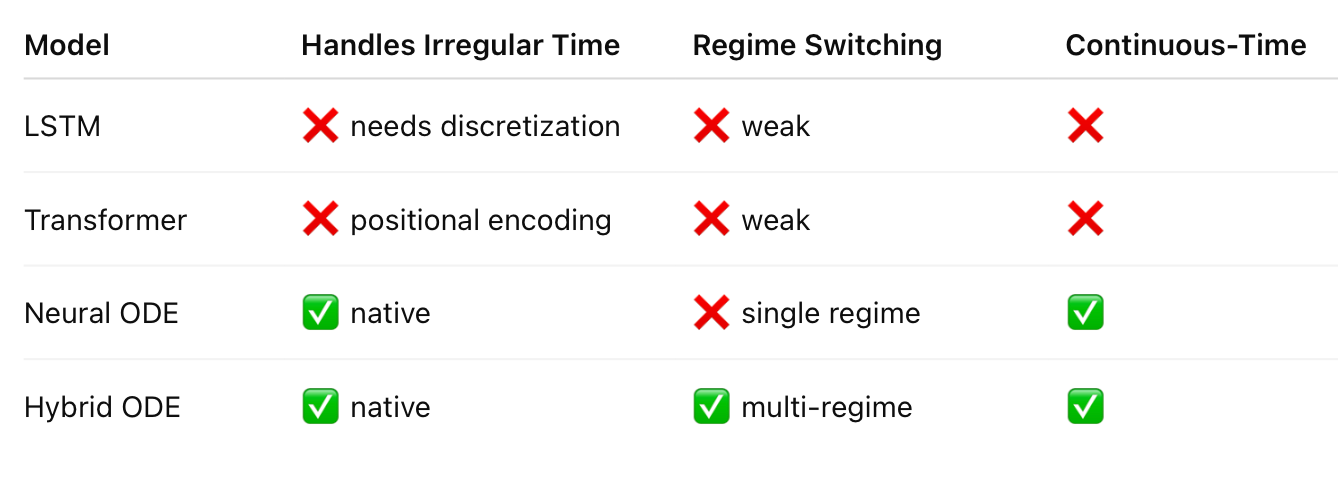

## **Conclusion**

LSTM and Transformer directly fit the observed point, while Neural ODE need to learn the underlying dynamics and integrate it with solver. On small synthetic data, discrete model such as LSTM and Transformer perform better and achieve lower error<br>

How to make Hybrid ODE Wins? <br>
1.Time is very long <br>
2.Time is more irregular

